In [52]:
%matplotlib inline
import numpy as np
import scipy
from matplotlib import pylab as plt
from matplotlib import rc
from matplotlib import rcParams
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso

In [53]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rcParams['text.latex.preamble'] = ["\usepackage{amsmath} "]

In [54]:
def ss_estimations(X_lab, X_all, y):
    InverseMatrix = np.linalg.inv(np.dot(np.transpose(X_all), X_all))
    beta = np.dot(np.dot(InverseMatrix, np.transpose(X_lab)), y)
    return beta / len(X_lab[:, 1]) * len(X_all[:,1])

def ols_estimations(X_lab, y):
    InverseMatrix = np.linalg.inv(np.dot(np.transpose(X_lab), X_lab))
    beta = np.dot(np.dot(InverseMatrix, np.transpose(X_lab)), y)
    return beta

def lasso_estimation(A, X, y, lamda = 1, iterations = 100):
    beta = np.ones((len(X[0,:])))
    dim = len(X[0, :])
    n_lab = len(X)
    for iterations_number in range(iterations):
        for i in range(len(beta)):
            A_i = A[:, i]
            first_coef = np.linalg.norm(A_i) ** 2 
            second_coef = np.dot(y,  X[:, i]) / n_lab - np.dot(np.dot(A_i,  A[:, np.arange(dim)!=i]), beta[np.arange(dim)!=i])
            if (second_coef - lamda) > 0:
                beta[i] = (second_coef - lamda)/(first_coef)
            elif (second_coef + lamda) < 0:
                beta[i] = (second_coef + lamda)/(first_coef)
            else:
                beta[i] = 0
    return beta

def generate_linear_data(n = 100, test_n = 5000, dim = 5, sparse = False):

    mu = range(dim)
    Sigma = np.random.normal(10, 10, dim * dim)
    Sigma = np.reshape(Sigma, (dim, dim))
    Sigma = np.dot(np.transpose(Sigma), Sigma)
    X = np.random.multivariate_normal(mu, Sigma, size = n)
    X = normalize(X)
    y = np.sum(X, axis = 1) + np.random.normal(0, 1, n)
    X_test = np.random.multivariate_normal(mu, Sigma, size = test_n)
    X_test = normalize(X_test)
    y_test = np.sum(X_test, axis = 1) + np.random.normal(0, 1, test_n)
    return (X,y,X_test, y_test)


def generate_nonlinear_data( n = 100, test_n = 5000, dim = 5, sparse = False):

    mu = range(dim)
    Sigma = np.random.normal(10, 10, dim * dim)
    Sigma = np.reshape(Sigma, (dim, dim))
    Sigma = np.dot(np.transpose(Sigma), Sigma)
    X = np.random.multivariate_normal(mu, Sigma, size = n)
    X = normalize(X)
    y = np.cos(X[:,0] + X[:,1])  + X[:, 4]**2 + np.random.normal(0, 1, n)
    
    X_test = np.random.multivariate_normal(mu, Sigma, size = test_n)
    X_test = normalize(X_test)
    y_test = np.cos(X_test[:,0] + X_test[:,1]) + X_test[:, 4]**2 + np.random.normal(0, 1, test_n)
    
    return (X,y,X_test,y_test)

def compute_rss(X, y, beta):
    predictions = np.dot(X, beta)
    return np.mean((y - predictions)**2)


def compute_lamda(n, p, delta = 0.3, B_X = 1, B_Y = 1):
    log_term = np.sqrt(np.log(6. * p / delta) / n)
    
    lamda = 8 * B_X * B_Y * log_term * (1 + B_X * log_term / 3)
    
    return lamda

def execute_simulations(generator ,begin = 50, end = 1000, step = 50, fold = 100, dim = 5, kernel = False, sparse = False, OLS = True):
    X, y, test_data_X, test_data_y = generator(end * fold, test_n = 5000, dim = dim, sparse = sparse)


    ols_risk = list()
    ss_risk = list()
    lasso_risk = list()
    lasso_ss_risk = list()
    kernel_risk = list()
    
    
    kreg = KernelRidge(kernel = 'rbf')
    for n in range(begin, end, step):
        all_length = n * fold
        X_all = np.concatenate([X[1:n,:], X[n:all_length,:]], axis = 0)
        
        if OLS == True:
            beta_ols = ols_estimations(X[1:n,:], y[1:n])
            ols_risk.append(compute_rss(test_data_X, test_data_y, beta_ols))

            beta_ss = ss_estimations(X[1:n,:], X_all, y[1:n])
            ss_risk.append(compute_rss(test_data_X, test_data_y, beta_ss))
        else:
            ols_risk.append(0)
            ss_risk.append(0)
        
        A = np.dot(np.transpose(X[1:n,:]), X[1:n,:])/n
        A = scipy.linalg.sqrtm(A)
        

        lamda = 0.1
        
        lasso_est = Lasso(fit_intercept=False, alpha=lamda)
        lasso_est.fit(X[1:n,:], y[1:n])
        y_pred = lasso_est.predict(test_data_X)
        
    

        lasso_risk.append(np.mean((test_data_y - y_pred)**2))

        
        A = np.dot(np.transpose(X_all), X_all)/len(X_all)
        
  
        A = scipy.linalg.sqrtm(A)
  
        
        beta_lasso_ss = lasso_estimation(A, X[1:n,:], y[1:n], lamda  = lamda)

        lasso_ss_risk.append(compute_rss(test_data_X, test_data_y, beta_lasso_ss))
        
        if kernel == True:
            kreg.fit(X[1:n,:], y[1:n])
            pred = kreg.predict(test_data_X)
            kernel_risk.append(np.mean((test_data_y - pred)**2))
        else:
            kernel_risk.append(0)
    
    ns = range(begin, end, step)
    result = np.array([ns, ols_risk, ss_risk, lasso_risk, lasso_ss_risk ,kernel_risk])

    return result


In [55]:
risk = execute_simulations(begin = 20, step = 5, end = 200, dim = 10, generator = generate_linear_data)
for i in range(100):
    a = execute_simulations(begin = 20, step = 5, end = 200, dim = 10, generator = generate_linear_data)
    risk += a
risk[0, :] = risk[0, :] / 100

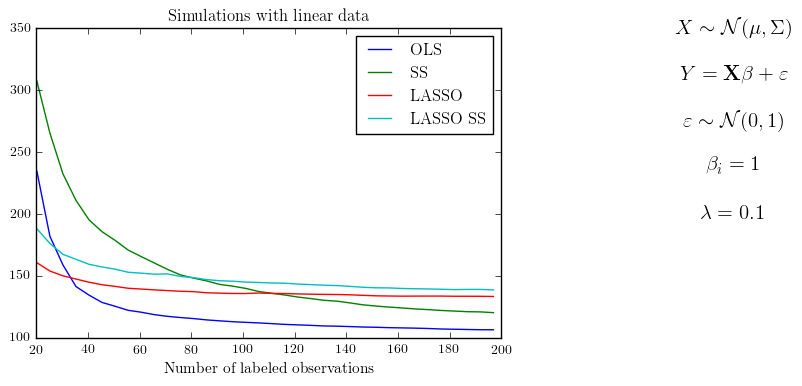

In [57]:
ax = plt.gca()
line_ols, = plt.plot(risk[0, :], risk[1, :], label = "OLS")
line_ss, = plt.plot(risk[0, :], risk[2, :], label = "SS")
line_lasso, = plt.plot(risk[0, :], risk[3, :], label = "LASSO")
line_lasso_ss, = plt.plot(risk[0, :], risk[4, :], label = "LASSO SS")


plt.legend(handles = [line_ols, line_ss, line_lasso, line_lasso_ss])
plt.title("Simulations with linear data")
plt.xlabel("Number of labeled observations", fontsize = 11)
plt.text(1.5, 1,r'$X \sim \mathcal{N} (\mu, \Sigma)$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.85,r'$Y = \mathbf{X}\beta + \varepsilon$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.7,r'$\varepsilon \sim \mathcal{N}(0,1)$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)

plt.text(1.5, 0.55,r'$\beta_i = 1$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15);

plt.text(1.5, 0.4,r'$\lambda = 0.1$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15);

The graph above describes the performance of the estimators in the case where $Y$ is generated as a linear combination of columns of matrix $X$ that was generated by multinomial normal distribution with random covariance matrix. Now we will check the prefomance by generating nonlinear $Y$. We will also compare our method with kernel regression.

In [58]:
risk = execute_simulations(begin = 20, step = 5, end = 200, dim = 10, kernel = True, generator= generate_nonlinear_data)
for i in range(100):
    a = execute_simulations(begin = 20, step = 5, end = 200, dim = 10, kernel = True, generator= generate_nonlinear_data)
    risk += a
risk[0, :] = risk[0, :] / 100

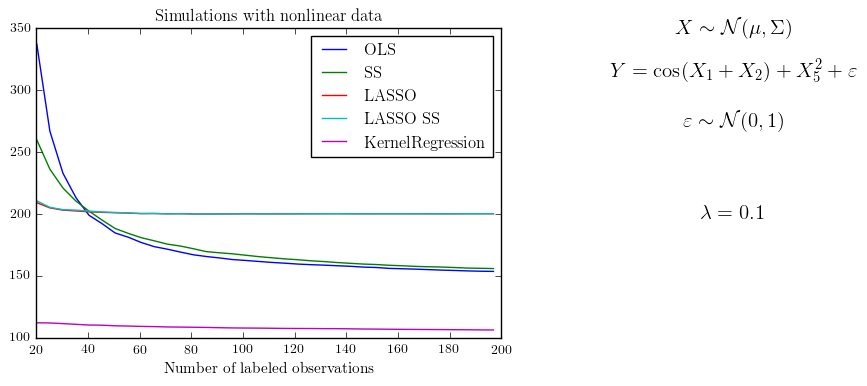

In [59]:
ax = plt.gca()
line_ols, = plt.plot(risk[0, :], risk[1, :], label = "OLS")
line_ss, = plt.plot(risk[0, :], risk[2, :], label = "SS")
line_lasso, = plt.plot(risk[0, :], risk[3, :], label = "LASSO")
line_lasso_ss, = plt.plot(risk[0, :], risk[4, :], label = "LASSO SS")
line_kernel, = plt.plot(risk[0, :], risk[5, :], label = "KernelRegression")
plt.legend(handles = [line_ols, line_ss, line_lasso, line_lasso_ss, line_kernel])
plt.title("Simulations with nonlinear data")
plt.xlabel("Number of labeled observations", fontsize = 11)

plt.text(1.5, 1,r'$X \sim \mathcal{N} (\mu, \Sigma)$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.85,r'$Y = \cos (X_1 + X_2) + X_5^2 + \varepsilon$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.7,r'$\varepsilon \sim \mathcal{N}(0,1)$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15);

plt.text(1.5, 0.4,r'$\lambda = 0.1$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15);


As we can see, kernel regression preforms much better. So it is even has no sense to compare it. Let us compare OLS and SS with linear and nonlinear data with a uniformly distributed data.

In [60]:
def generate_uniform_linear(n = 100, test_n = 5000, dim = 5, sparse = False):
    X = np.random.normal(0, 1, (n, dim))
    X = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x ** 2)), 1, X)
    beta = np.random.random(dim) * 2
    if sparse == True:
        sparcity_vector = np.random.binomial(1, 0.2, size=dim)
        beta = sparcity_vector * beta
    
    y = np.dot(X, beta) + np.random.normal(0, 1, n)
    X_test = np.random.normal(0, 1, (test_n, dim))
    X_test = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x ** 2)), 1, X_test)
    y_test = np.dot(X_test, beta) + np.random.normal(0, 1, test_n)
    
    return (X, y, X_test, y_test)

In [61]:
risk = execute_simulations(begin = 25, end = 200, dim = 20, step = 5, generator= generate_uniform_linear, sparse = True)
for i in range(100):
    a = execute_simulations(begin = 25, end = 200, dim = 20, step = 5,  generator= generate_uniform_linear, sparse = True)
    risk += a
risk[0, :] = risk[0, :] / 100

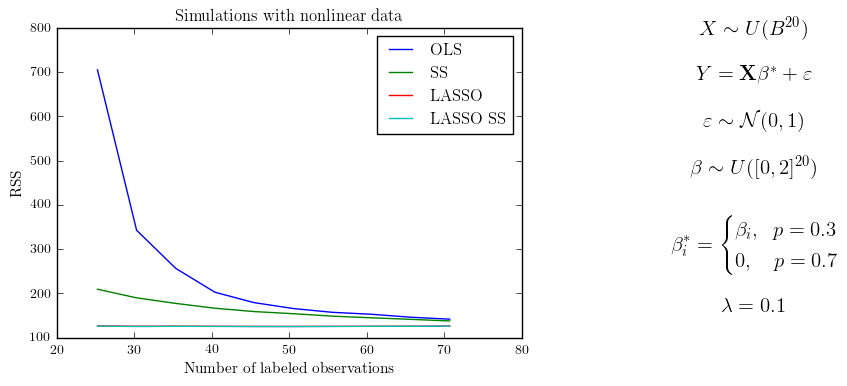

In [63]:
ax = plt.gca()
line_ols, = plt.plot(risk[0, :10], risk[1, :10], label = "OLS")
line_ss, = plt.plot(risk[0, :10], risk[2, :10], label = "SS")
line_lasso, = plt.plot(risk[0, :10], risk[3, :10], label = "LASSO")
line_lasso_ss, = plt.plot(risk[0, :10], risk[4, :10], label = "LASSO SS")
plt.legend(handles = [line_ols, line_ss, line_lasso, line_lasso_ss])
plt.title("Simulations with nonlinear data")
plt.ylabel("RSS", fontsize = 11)
plt.xlabel("Number of labeled observations", fontsize = 11)

plt.text(1.5, 1,r'$X \sim U (B^{20})$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.85,r'$Y = \mathbf{X}\beta^* + \varepsilon$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.7,r'$\varepsilon \sim \mathcal{N}(0,1)$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)

plt.text(1.5, 0.55,r'$\beta \sim U([0,2]^{20})$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15);


plt.text(1.5, 0.3,
         r'\begin{equation*} \beta_i^* = \begin{cases} \beta_i, \hspace{3mm} p = 0.3 \\ 0, \hspace{5mm}  p = 0.7 \end{cases}\end{equation*}', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15);

plt.text(1.5, 0.1,r'$\lambda = 0.1$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15);

In [86]:
def generate_uniform_nonlinear(n = 100, test_n = 5000, dim = 5, sparse = False):
    X = np.random.normal(0, 1, (n, dim))
    X = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x ** 2)), 1, X) * 10

    
    #y = np.dot(X, beta) + np.random.normal(0, 1, n)
    y = X[:, 1] ** 2  + X[:, 2] * X[:, 3] + np.random.normal(0, 1, n)
    X_test = np.random.normal(0, 1, (test_n, dim))
    X_test = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x ** 2)), 1, X_test)
    #y_test = np.dot(X_test, beta) + np.random.normal(0, 1, test_n)
    y_test = X_test[:, 1] ** 2 + X_test[:, 2] * X_test[:, 3] + np.random.normal(0, 1, test_n)
    return (X, y, X_test, y_test)

In [87]:
risk = execute_simulations(begin = 10, end = 200, dim = 5, step = 5, generator = generate_uniform_nonlinear)
for i in range(100):
    a = execute_simulations(begin = 10, end = 200, dim = 5, step = 5, generator = generate_uniform_nonlinear)
    risk += a
risk[0, :] = risk[0, :] / 100

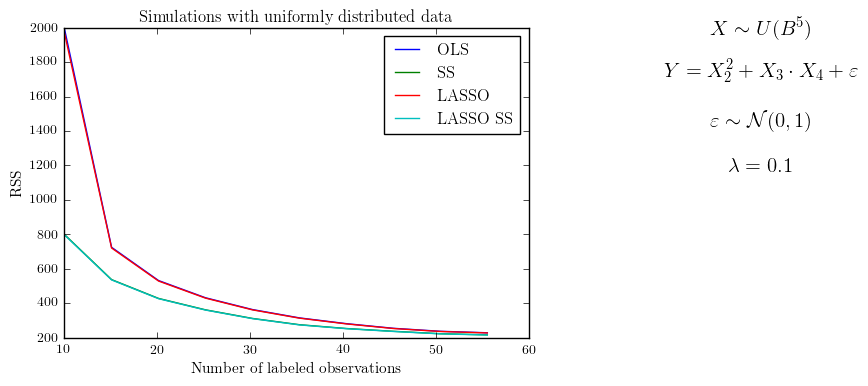

In [89]:
ax = plt.gca()
line_ols, = plt.plot(risk[0, :10], risk[1, :10], label = "OLS")
line_ss, = plt.plot(risk[0, :10], risk[2, :10], label = "SS")
line_lasso, = plt.plot(risk[0, :10], risk[3, :10], label = "LASSO")
line_lasso_ss, = plt.plot(risk[0, :10], risk[4, :10], label = "LASSO SS")
plt.legend(handles = [line_ols, line_ss, line_lasso, line_lasso_ss])


plt.xlabel("Number of labeled observations", fontsize = 11)
plt.ylabel("RSS", fontsize = 11)
plt.title("Simulations with uniformly distributed data");
plt.text(1.5, 1,r'$X \sim U (B^5) \cdot 10$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.85,r'$Y = X_2^2 + X_3 \cdot X_4 + \varepsilon$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.7,r'$\varepsilon \sim \mathcal{N}(0,1)$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)

plt.text(1.5, 0.55,r'$\lambda = 0.1$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15);

# Case where dimension is higher than number of observations

In [90]:
risk = execute_simulations(begin = 10, end = 100, dim = 50, step = 5, generator = generate_uniform_nonlinear, OLS = False)
for i in range(100):
    a = execute_simulations(begin = 10, end = 100, dim = 50, step = 5, generator = generate_uniform_nonlinear, OLS = False)
    risk += a
risk[0, :] = risk[0, :] / 100

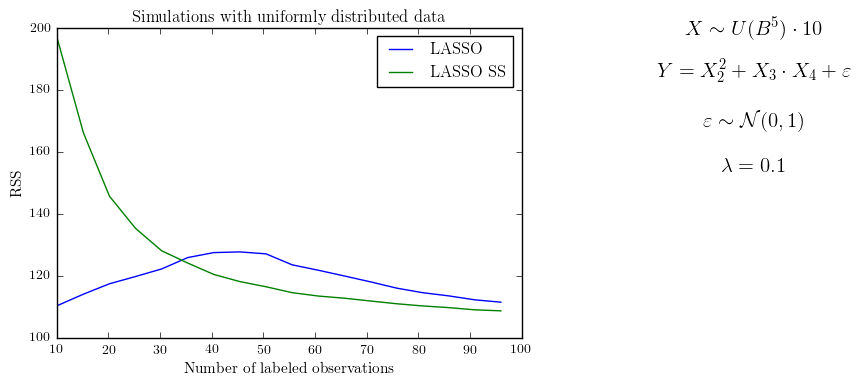

In [92]:
ax = plt.gca()

line_lasso, = plt.plot(risk[0, :], risk[3, :], label = "LASSO")
line_lasso_ss, = plt.plot(risk[0, :], risk[4, :], label = "LASSO SS")
plt.legend(handles = [line_lasso, line_lasso_ss])


plt.xlabel("Number of labeled observations", fontsize = 11)
plt.ylabel("RSS", fontsize = 11)
plt.title("Simulations with uniformly distributed data");
plt.text(1.5, 1,r'$X \sim U (B^5) \cdot 10$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.85,r'$Y = X_2^2 + X_3 \cdot X_4 + \varepsilon$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.7,r'$\varepsilon \sim \mathcal{N}(0,1)$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.55,r'$\lambda = 0.1$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15);

# Now we will consider the case with uniform noise

In [96]:
def generate_uniform_nonlinear(n = 100, test_n = 5000, dim = 5, sparse = False):
    X = np.random.normal(0, 1, (n, dim))
    X = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x ** 2)), 1, X) * 3

    
    #y = np.dot(X, beta) + np.random.normal(0, 1, n)
    y = X[:, 1] ** 2  + X[:, 2] * X[:, 3] + np.random.uniform(0, 1, n)
    X_test = np.random.normal(0, 1, (test_n, dim))
    X_test = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x ** 2)), 1, X_test)
    #y_test = np.dot(X_test, beta) + np.random.normal(0, 1, test_n)
    y_test = X_test[:, 1] ** 2 + X_test[:, 2] * X_test[:, 3] + np.random.uniform(0, 1, n)
    return (X, y, X_test, y_test)

In [97]:
risk = execute_simulations(begin = 10, end = 100, dim = 50, step = 5, generator = generate_uniform_nonlinear, OLS = False)
for i in range(100):
    a = execute_simulations(begin = 10, end = 100, dim = 50, step = 5, generator = generate_uniform_nonlinear, OLS = False)
    risk += a
risk[0, :] = risk[0, :] / 100

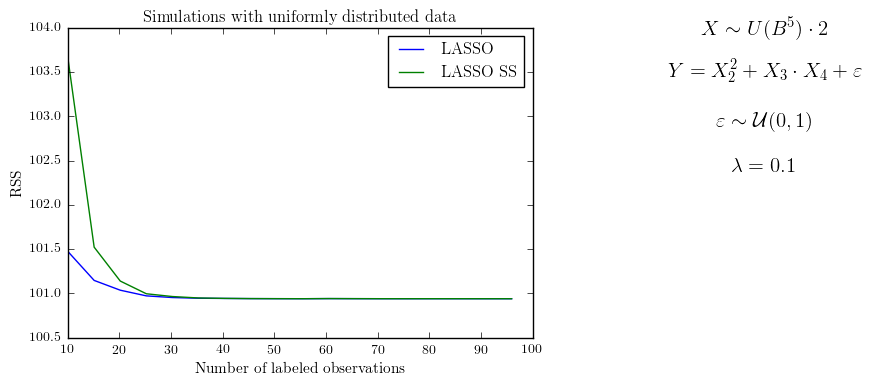

In [99]:
ax = plt.gca()

line_lasso, = plt.plot(risk[0, :], risk[3, :], label = "LASSO")
line_lasso_ss, = plt.plot(risk[0, :], risk[4, :], label = "LASSO SS")
plt.legend(handles = [line_lasso, line_lasso_ss])


plt.xlabel("Number of labeled observations", fontsize = 11)
plt.ylabel("RSS", fontsize = 11)
plt.title("Simulations with uniformly distributed data");
plt.text(1.5, 1,r'$X \sim U (B^5) \cdot 3$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.85,r'$Y = X_2^2 + X_3 \cdot X_4 + \varepsilon$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.7,r'$\varepsilon \sim \mathcal{U}(0,1)$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.55,r'$\lambda = 0.1$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15);

# Normal truncated noise

In [ ]:
import scipy

def generate_uniform_nonlinear(n = 100, test_n = 5000, dim = 5, sparse = False):
    X = np.random.normal(0, 1, (n, dim))
    X = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x ** 2)), 1, X) * 

    
    #y = np.dot(X, beta) + np.random.normal(0, 1, n)
    y = X[:, 1] ** 2  + X[:, 2] * X[:, 3] + scipy.stats.truncnorm.rvs(-2,2, n)
    X_test = np.random.normal(0, 1, (test_n, dim))
    X_test = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x ** 2)), 1, X_test)
    #y_test = np.dot(X_test, beta) + np.random.normal(0, 1, test_n)
    y_test = X_test[:, 1] ** 2 + X_test[:, 2] * X_test[:, 3] + scipy.stats.truncnorm.rvs(-2,2, n)
    return (X, y, X_test, y_test)

In [ ]:
risk = execute_simulations(begin = 10, end = 100, dim = 50, step = 5, generator = generate_uniform_nonlinear, OLS = False)
for i in range(100):
    a = execute_simulations(begin = 10, end = 100, dim = 50, step = 5, generator = generate_uniform_nonlinear, OLS = False)
    risk += a
risk[0, :] = risk[0, :] / 100

In [ ]:
ax = plt.gca()

line_lasso, = plt.plot(risk[0, :], risk[3, :], label = "LASSO")
line_lasso_ss, = plt.plot(risk[0, :], risk[4, :], label = "LASSO SS")
plt.legend(handles = [line_lasso, line_lasso_ss])


plt.xlabel("Number of labeled observations", fontsize = 11)
plt.ylabel("RSS", fontsize = 11)
plt.title("Simulations with uniformly distributed data");
plt.text(1.5, 1,r'$X \sim U (B^5) \cdot 2$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.85,r'$Y = X_2^2 + X_3 \cdot X_4 + \varepsilon$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.7,r'$\varepsilon \sim \mathcal{N}_T[-2, 2]$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.55,r'$\lambda = 0.1$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15);

# Simulations with different lambda